In [2]:
import pandas as pd
import numpy as np
from io import StringIO
from classes import BalancedUndersamplingShuffle, balanced_sampling
from helpers import plot_learning_curve, plot_validation_curve, fit_and_score_pipeline, \
    fit_and_score_iteratively, plot_validation_curve_with_undersampling
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.metrics import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC


In [3]:
from scipy.io import arff

with open('1year.arff','r') as f:
    data1, meta1 = arff.loadarff(f)
    data1 = np.asarray(data1.tolist(), dtype=np.float32)
    print(data1.shape)

with open('2year.arff','r') as f:
    data2, meta2 = arff.loadarff(f)
    data2 = np.asarray(data2.tolist(), dtype=np.float32)
    print(data2.shape)

with open('3year.arff','r') as f:
    data3, meta3 = arff.loadarff(f)
    data3 = np.asarray(data3.tolist(), dtype=np.float32)
    print(data3.shape)

with open('4year.arff','r') as f:
    data4, meta4 = arff.loadarff(f)
    data4 = np.asarray(data4.tolist(), dtype=np.float32)
    print(data4.shape)

with open('5year.arff','r') as f:
    data5, meta5 = arff.loadarff(f)
    data5 = np.asarray(data5.tolist(), dtype=np.float32)
    print(data5.shape)


(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [4]:
data = np.concatenate([data1, data2, data3, data4, data5], axis=0)
data[np.isnan(data)] = 0

X, y = data[:,:-1], data[:, -1]
y[y==0] = -1

print(f'X.shape={X.shape}, y.shape={y.shape}')

X.shape=(43405, 64), y.shape=(43405,)


# Naive fit

In [6]:
# No undersampling
classifier = SVC()
pipe = make_pipeline(StandardScaler(), classifier)
res = fit_and_score_iteratively(pipe, X, y, None, 10)
print(res)

# With undersampling
classifier = SVC()
pipe = make_pipeline(StandardScaler(), classifier)
res = fit_and_score_iteratively(pipe, X, y, 1, 10)
print(res)


[0.95185071 0.00317965 0.5        0.0015949  0.50075711]
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.65298805 0.62947415 0.67542352 0.59393939 0.65294103]


# Hyperparameter tuning

param=linear
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=poly
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=rbf
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=sigmoid
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


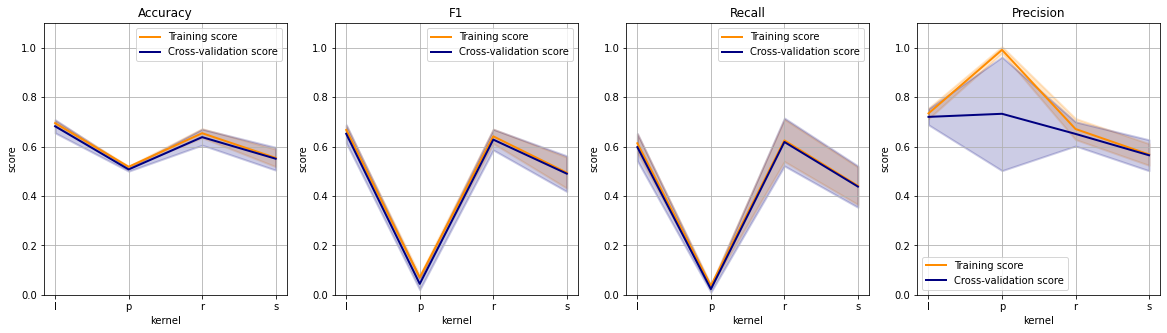

In [4]:
# optimize kernal

# regularization_param = 1
# # kernal = 'rbf' #{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
# degree = 3 # polynormal kernal degree, ignored by all other kernals, default=3
# gamma = 'scale' # gamma{‘scale’, ‘auto’} or float, default=’scale’
# coef0 = 0.0 # float, Independent term in kernel function. Only significant in ‘poly’ and ‘sigmoid’. default=0.0
# # shrinkingbool, default=True
# # probabilitybool, default=False
# # tolfloat, default=1e-3 Tolerance for stopping criterion.
# max_iter = -1 #int, default=-1
# random_state = 0 #int default= None
classifier = SVC()
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

param_range = ('linear', 'poly', 'rbf', 'sigmoid')

scoring = ['accuracy', 'f1', 'recall', 'precision']

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='kernel', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, 
                      x_axis_is_log=False, is_pipe=True)


In [5]:
results_store

{'fit_time': array([['linear', '1.4752903127670287', '0.44026456117951673'],
        ['poly', '1.4910679101943969', '0.5089040848176417'],
        ['rbf', '2.0078055477142334', '0.7521127704512831'],
        ['sigmoid', '1.8433140087127686', '0.7363746809141856']],
       dtype='<U19'),
 'score_time': array([['linear', '0.07331805706024169', '0.03258053605444676'],
        ['poly', '0.106338152885437', '0.04390463194787277'],
        ['rbf', '0.13819396018981933', '0.04590091410384466'],
        ['sigmoid', '0.2505533456802368', '0.15303461286179132']],
       dtype='<U19'),
 'test_accuracy': array([['linear', '0.6820339894338212', '0.02681561212945336'],
        ['poly', '0.5073766889522652', '0.007175139820121804'],
        ['rbf', '0.638110711113189', '0.03240026447203856'],
        ['sigmoid', '0.5507604376081163', '0.04630951812146177']],
       dtype='<U20'),
 'train_accuracy': array([['linear', '0.6947479361806889', '0.010634727147591371'],
        ['poly', '0.5180251747083875',

[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000]
param=0.0001
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=19.767464114832535


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


param=0.001
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=19.767464114832535


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


param=0.005
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=19.767464114832535


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


param=0.01
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=19.767464114832535


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


param=0.05
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535
a=0.0, r=1, gamma=19.767464114832535
param=0.1
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535
a=0.0, r=1, gamma=19.767464114832535
param=0.5
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535
a=0.0, r=1, gamma=19.767464114832535
param=1
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535
a=0.0, r=1, gamma=19.767464114832535
param=11
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535
a=0.0, r=1, gamma=19.767464114832535
param=21
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535
a=0.0, r=1, gamma=19.767464114832535
param=31
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535
a=0.0, r=1, gamma=19.767464114832535
param=41
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.767464114832535
a=0.0, r=1, gamma=19.767464114832535
param=51
<class 'sklearn.pipeline.Pipeline'>


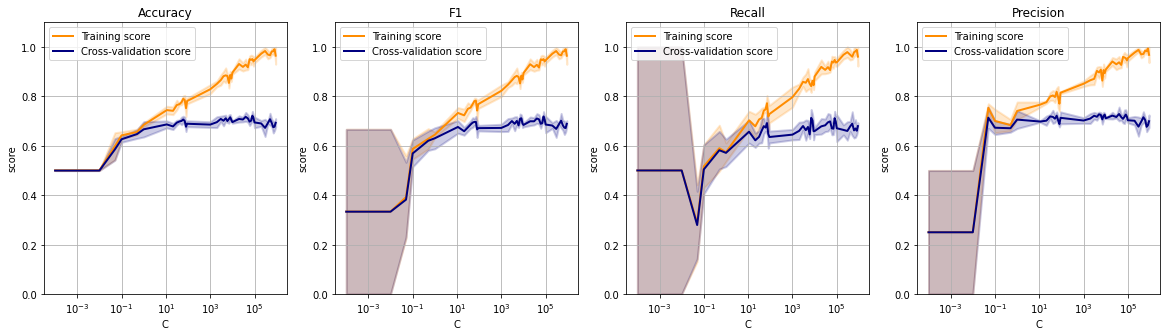

In [26]:
# optimize kernal

# regularization_param = 1
# # kernal = 'rbf' #{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
# degree = 3 # polynormal kernal degree, ignored by all other kernals, default=3
# gamma = 'scale' # gamma{‘scale’, ‘auto’} or float, default=’scale’
# coef0 = 0.0 # float, Independent term in kernel function. Only significant in ‘poly’ and ‘sigmoid’. default=0.0
# # shrinkingbool, default=True
# # probabilitybool, default=False
# # tolfloat, default=1e-3 Tolerance for stopping criterion.
# max_iter = -1 #int, default=-1
# random_state = 0 #int default= None
classifier = SVC(kernel='rbf')
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)

param_range = [1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 5e-1, 1e-1] + list(range(1, 100, 10)) + list(range(1000, 10000, 1000)) +\
    list(range(10000, 100000, 10000)) + list(range(100000, 1000000, 100000))
param_range.sort()

print(param_range)

scoring = ['accuracy', 'f1', 'recall', 'precision']

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='C', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=2, undersampling_ratio=1, 
                      x_axis_is_log=True, is_pipe=True)


In [28]:
results_store

{'fit_time': array([[1.00000000e-04, 6.66476488e-02, 1.23755217e-03],
        [1.00000000e-03, 6.83395267e-02, 2.93607903e-03],
        [5.00000000e-03, 2.73909211e-01, 1.98321376e-02],
        [1.00000000e-02, 6.54039979e-02, 6.34678506e-04],
        [5.00000000e-02, 7.49555826e-02, 6.31479927e-03],
        [1.00000000e-01, 6.83802962e-02, 5.85366476e-03],
        [5.00000000e-01, 6.32935762e-02, 2.07643129e-03],
        [1.00000000e+00, 6.51842952e-02, 7.49103303e-03],
        [1.10000000e+01, 1.49353623e-01, 9.24502051e-02],
        [2.10000000e+01, 1.91111267e-01, 5.45142377e-02],
        [3.10000000e+01, 6.10073209e-02, 2.22747728e-03],
        [4.10000000e+01, 6.02340102e-02, 1.38417901e-03],
        [5.10000000e+01, 6.36370778e-02, 1.77285823e-03],
        [6.10000000e+01, 6.67142272e-02, 4.60813045e-03],
        [7.10000000e+01, 7.09512830e-02, 6.41155646e-03],
        [8.10000000e+01, 7.33112097e-02, 9.13944360e-03],
        [9.10000000e+01, 1.80311561e-01, 1.13766453e-01],
  

param=1
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=2
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=3
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=4
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=5
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=6
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


param=7
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=8
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=9
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=19.753415300546447
param=10
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


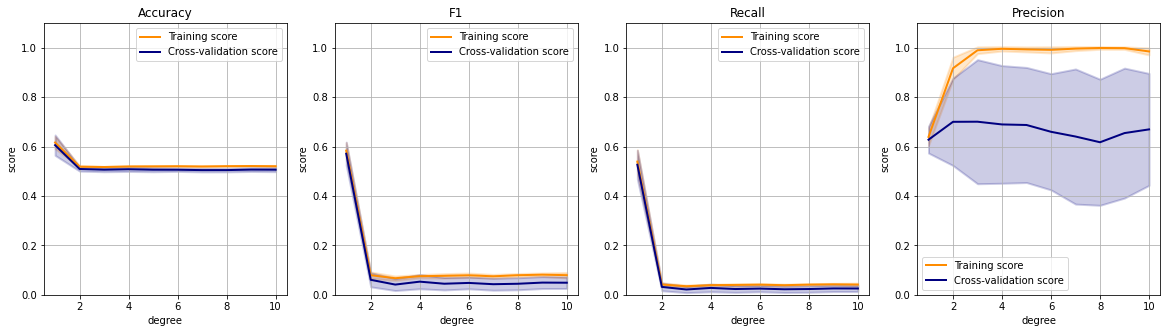

In [30]:
# optimize kernal

# regularization_param = 1
# # kernal = 'rbf' #{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
# degree = 3 # polynormal kernal degree, ignored by all other kernals, default=3
# gamma = 'scale' # gamma{‘scale’, ‘auto’} or float, default=’scale’
# coef0 = 0.0 # float, Independent term in kernel function. Only significant in ‘poly’ and ‘sigmoid’. default=0.0
# # shrinkingbool, default=True
# # probabilitybool, default=False
# # tolfloat, default=1e-3 Tolerance for stopping criterion.
# max_iter = -1 #int, default=-1
# random_state = 0 #int default= None
classifier = SVC(kernel='poly')
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

param_range = range(1, 11)

scoring = ['accuracy', 'f1', 'recall', 'precision']

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='degree', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, 
                      x_axis_is_log=False, is_pipe=True)


In [31]:
results_store

{'fit_time': array([[ 1.        ,  1.1722569 ,  0.3749089 ],
        [ 2.        ,  1.31406597,  0.50040969],
        [ 3.        ,  1.69356411,  0.69758772],
        [ 4.        ,  1.66609057,  0.66472773],
        [ 5.        ,  1.55798707,  0.55976284],
        [ 6.        ,  1.60797173,  0.56732043],
        [ 7.        ,  1.89376818,  0.76735934],
        [ 8.        ,  1.72040592,  0.61329033],
        [ 9.        ,  1.71696864,  0.58527986],
        [10.        ,  2.31910247,  1.06996914]]),
 'score_time': array([[ 1.        ,  0.08112551,  0.02884155],
        [ 2.        ,  0.08565775,  0.03199194],
        [ 3.        ,  0.13687664,  0.09086426],
        [ 4.        ,  0.11197481,  0.05819527],
        [ 5.        ,  0.09729183,  0.04578831],
        [ 6.        ,  0.11146114,  0.06700944],
        [ 7.        ,  0.11140069,  0.06936188],
        [ 8.        ,  0.08658817,  0.02688204],
        [ 9.        ,  0.11254613,  0.06129363],
        [10.        ,  0.07086946,  0.026

# Performance

In [8]:
# Try different kernels
# undersampling to 1-1
classifier = SVC(kernel='linear')
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
res = fit_and_score_iteratively(pipe, X, y, undersampling_ratio=1, iterations=3, use_validation_set=False,
                               include_train_results=False)
print(res)


# Undersampling to 1:1 and iteration 10x
classifier = SVC(kernel='rbf')
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
res = fit_and_score_iteratively(pipe, X, y, undersampling_ratio=1, iterations=3, use_validation_set=False,
                               include_train_results=False)
print(res)


# Undersampling to 1:1 and iteration 10x
classifier = SVC(kernel='poly')
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
res = fit_and_score_iteratively(pipe, X, y, undersampling_ratio=1, iterations=3, use_validation_set=False,
                               include_train_results=False)
print(res)

# Undersampling to 1:1 and iteration 10x
classifier = SVC(kernel='sigmoid')
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
res = fit_and_score_iteratively(pipe, X, y, undersampling_ratio=1, iterations=3, use_validation_set=False,
                               include_train_results=False)
print(res)



a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.68366534 0.6555826  0.71982627 0.60287081 0.68360101]
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.66374502 0.6506305  0.67584616 0.62892079 0.66371729]
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.5059761  0.05001215 0.62978996 0.02604997 0.50559399]
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.50889774 0.41377593 0.5109843  0.3492823  0.50877066]


In [29]:
# model performance
# kernel = rbf, C= 80000
classifier = SVC(kernel='rbf', C=80000)
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
res = fit_and_score_iteratively(pipe, X, y, undersampling_ratio=1, iterations=3, use_validation_set=False,
                               include_train_results=False)
print(res)


a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.76015936 0.76014057 0.7597175  0.76076555 0.76015985]


In [34]:
# model performance
# kernel = poly, degree = 1
classifier = SVC(kernel='poly', degree=1)
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
res = fit_and_score_iteratively(pipe, X, y, undersampling_ratio=1, iterations=3, use_validation_set=False,
                               include_train_results=False)
print(res)


a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.59335989 0.57201722 0.60513671 0.54651781 0.5933226 ]


In [35]:
# model performance
# kernel = linear
classifier = SVC(kernel='linear')
pipe = make_pipeline(StandardScaler(), classifier)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
res = fit_and_score_iteratively(pipe, X, y, undersampling_ratio=1, iterations=3, use_validation_set=False,
                               include_train_results=False)
print(res)


a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.67702523 0.67489863 0.67934484 0.67198299 0.67702122]


### Regularization

# Learning curve

iteration 1
a=0.0, r=1, gamma=20.040858725761773
{'train_sizes': array([ 161,  323,  484,  646,  808,  969, 1131, 1292, 1454, 1616]), 'train_scores_mean': array([0.75279503, 0.73498452, 0.68471074, 0.68328173, 0.68688119,
       0.67719298, 0.67303271, 0.62987616, 0.61416781, 0.59863861]), 'train_scores_std': array([0.04485831, 0.01811609, 0.03601448, 0.03183891, 0.00980773,
       0.02686669, 0.03117209, 0.04419064, 0.04031928, 0.04394453]), 'test_scores_mean': array([0.59474759, 0.61950251, 0.60859797, 0.60117956, 0.62938516,
       0.61700281, 0.61502017, 0.60364014, 0.59274172, 0.58432221]), 'test_scores_std': array([0.02669247, 0.01664228, 0.0377291 , 0.02911259, 0.01590102,
       0.02233567, 0.03439235, 0.03267038, 0.04232549, 0.05300252]), 'fit_times_mean': array([0.09604011, 0.3257443 , 0.46662388, 0.84235978, 0.99096856,
       1.26756444, 2.00154185, 1.55057139, 0.98581777, 1.48535886]), 'fit_times_std': array([0.04487504, 0.1161587 , 0.24459905, 0.55340605, 0.59154393,
    

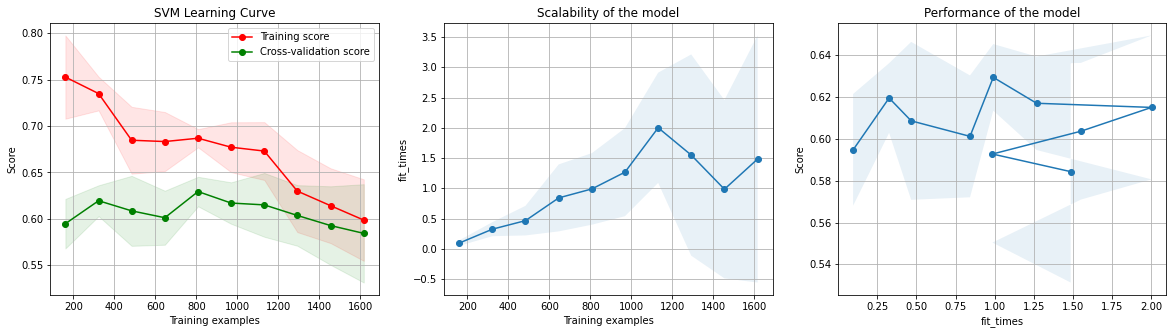

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier = SVC(C=80000,
                 kernel='rbf',
                 random_state=0
                )
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
pipe = make_pipeline(StandardScaler(), classifier)
title = 'SVM Learning Curve'
results = plot_learning_curve(classifier, title, X_train, y_train, axes=None, ylim=None, cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy',
                         undersampling=True)
print(results)

# Old code

[['linear' '0.05263157894736842' '0.027210884353741496' '0.8'
  '0.7542662116040956']
 ['poly' '0.03846153846153846' '0.02040816326530612' '0.3333333333333333'
  '0.7440273037542662']
 ['rbf' '0.026845637583892617' '0.013605442176870748' '1.0'
  '0.7525597269624573']
 ['sigmoid' '0.22222222222222224' '0.14285714285714285' '0.5'
  '0.7491467576791809']]
[0.05263158 0.02721088 0.8        0.75426621]
[0.03846154 0.02040816 0.33333333 0.7440273 ]
[0.02684564 0.01360544 1.         0.75255973]
[0.22222222 0.14285714 0.5        0.74914676]


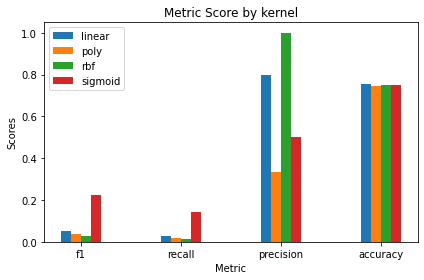

In [41]:
test_results_array = np.array(test_results)
train_results_array = np.array(train_results)
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


print(test_results_array)
labels = ['f1', 'recall', 'precision', 'accuracy']
test_linear = test_results_array[0, 1:].astype(float)
test_poly = test_results_array[1, 1:].astype(float)
test_rbf = test_results_array[2, 1:].astype(float)
test_sigmoid = test_results_array[3, 1:].astype(float)


print(test_linear)
print(test_poly)
print(test_rbf)
print(test_sigmoid)
# men_means = [20, 34, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/4*6, test_linear, width, label='linear')
rects2 = ax.bar(x - width/4*2, test_poly, width, label='poly')
rects3 = ax.bar(x + width/4*2, test_rbf, width, label='rbf')
rects4 = ax.bar(x + width/4*6, test_sigmoid, width, label='sigmoid')


# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xlabel('Metric')
ax.set_title('Metric Score by kernel')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)
# ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()
